## Setup

In [ ]:
! pip install neuralogic
from neuralogic.core import Template, R, V
from neuralogic.dataset import Dataset
from neuralogic.nn import get_evaluator
from neuralogic.core.settings import Settings
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 21.3 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
_, dataset = Mutagenesis()

template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])


template.add_rules([
    (R.bond_embed(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])

template +=  R.layer_1(V.X) <= (R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B))

template +=  R.layer_2(V.X) <= (R.layer_1(V.X)[3, 3], R.layer_1(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B))
template +=  R.layer_3(V.X) <= (R.layer_2(V.X)[3, 3], R.layer_2(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B))


template += R.predict[1, 3] <= R.layer_3(V.X)

## General rules

In [ ]:
template += R.bond_message(V.X, V.Y, V.B) <= (R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.bond_embed(V.B)[3,3])

template += R.single_bonded(V.X, V.Y) <= (R.single_bonded(V.X, V.Y, V.B))
template += R.single_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.b_1(V.B))

template += R.double_bonded(V.X, V.Y) <= (R.double_bonded(V.X, V.Y, V.B))
template += R.double_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B))

template += R.triple_bonded(V.X, V.Y) <= (R.triple_bonded(V.Y, V.X, V.B))
template += R.triple_bonded(V.X, V.Y, V.B) <= (R.bond(V.Y, V.X, V.B), R.b_3(V.B))

template += R.aromatic_bonded(V.X, V.Y) <= (R.aromatic_bonded(V.X, V.Y, V.B))# maybe also 4, 5 - contained on furan ring both on same oxygen
template += R.aromatic_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.b_7(V.B))

In [ ]:
from neuralogic.core import Aggregation


template += R.saturated(V.X) <= (R.c(V.X),
                                 R._single_bonded(V.X, V.Y1),
                                 R._single_bonded(V.X, V.Y2),
                                 R._single_bonded(V.X, V.Y3),
                                 R._single_bonded(V.X, V.Y4),
                                 R.special.alldiff(...))
template += (R.saturated <= (R.saturated(V.X))) | [Aggregation.MIN]

In [ ]:
template.add_rules([
    (R.halogen(V.X)[3,] <= R.get(atom)(V.X)) for atom in ["f", "cl", "br", "i"]
])
template += R.halogen_group(V.Y) <= (R.halogen(V.X), R._single_bonded(V.X, V.Y, V.B), R.bond_message(V.X, V.Y, V.B))

In [ ]:
template += R.hydroxyl(V.O) <= (R.o(V.O), R.h(V.H), 
                                R._single_bonded(V.O, V.H, V.B),
                                R.bond_message(V.O, V.H, V.B))

template += R.carbonyl_group(V.C, V.O) <= (R.c(V.C), R.o(V.O), R._double_bonded(V.O, V.C, V.B), R.bond_messages(V.O, V.C, V.B))
template += R.carbonyl_group(V.C, V.O, V.R1, V.R2) <= (R.carbonyl_group(V.C, V.O),
                                                       R._single_bonded(V.C, V.R1, V.B1), R._single_bonded(V.C, V.R2, V.B2),
                                                       R.bond_messages(V.C, V.R1, V.B1),
                                                       R.bond_messages(V.C, V.R2, V.B2), 
                                                       R.special.alldiff(...))

In [ ]:
template += R.path(V.X, V.Y, 0) <= (R.bond_embed(V.B)[3, 3], R._bond(V.X, V.Y, V.B)) 
template += R.path(V.X, V.Y, V.T) <= (R.bond_embed(V.B)[3, 3], R.path(V.Z, V.Y, V.T1)[3, 3], R._bond(V.X, V.Z, V.B), R.special.next(V.T1, V.T))

max_depth = 5
template += (R._next(i, i + 1) for i in range(max_depth))
template += (R.path(V.X, V.Y) <= (R.path(V.X, V.Y, max_depth)))

In [ ]:
template += R.functional_group(V.X) <= R.hydroxyl(V.X)[3, 3]
template += R.functional_group(V.X, V.Y) <= R.carbonyl_group(V.X, V.Y)[3, 3]

## Hydrocarbons

In [ ]:
template += R.benzene_ring(V.A) <= R.benzene_ring(V.A, V.B) # in a ring
template += R.benzene_ring(V.A, V.B) <= R.benzene_ring(V.A, V.B, V.C, V.D, V.E, V.F) # in the same ring

template += R.benzene_ring(V.A, V.B, V.C, V.D, V.E, V.F) <= (R._aromatic_bonded(V.A, V.B, V.B1), 
                                                             R._aromatic_bonded(V.B, V.C, V.B2),
                                                             R._aromatic_bonded(V.C, V.D, V.B3),
                                                             R._aromatic_bonded(V.D, V.E, V.B4),
                                                             R._aromatic_bonded(V.E, V.F, V.B5),
                                                             R._aromatic_bonded(V.F, V.A, V.B6),
                                                             R.c(V.A), R.c(V.B), R.c(V.C),
                                                             R.c(V.D), R.c(V.E), R.c(V.F),
                                                             R.bond_message(V.A, V.B, V.B1), 
                                                             R.bond_message(V.B, V.C, V.B2),
                                                             R.bond_message(V.C, V.D, V.B3),
                                                             R.bond_message(V.D, V.E, V.B4),
                                                             R.bond_message(V.E, V.F, V.B5),
                                                             R.bond_message(V.F, V.A, V.B6),

                                                             
                                                             R.special.alldiff(...))

In [ ]:
template += R.alkene_bond(V.C1, V.C2) <= (R.c(V.C1), R.c(V.C2), R._double_bonded(V.C1, V.C2, V.B), R.bond_message(V.C1, V.C2, V.B))
template += R.alkyne_bond(V.C1, V.C2) <= (R.c(V.C1), R.c(V.C2), R._triple_bonded(V.C1, V.C2, V.B), R.bond_message(V.C1, V.C2, V.B))

In [ ]:
template += R.functional_group(V.C1) <= R.alkene_bond(V.C1, V.C2)[3, 3]
template += R.functional_group(V.C1) <= R.alkyne_bond(V.C1, V.C2)[3, 3]
template += R.functional_group(V.A) <= R.benzene_ring(V.A)[3, 3]
template += R.functional_group(V.X) <= R.halogen_group(V.X)[3, 3]

## Carbonyls


In [ ]:
template += R.alcoholic(V.C) <= (R._saturated(V.C), 
                                 R.hydroxyl(V.O),
                                 R._single_bonded(V.C, V.O, V.B1),
                                 R.bond_message(V.C, V.O, V.B1))

template += R.ketone(V.C) <= (R.carbonyl_group(V.C, V.O, V.R1, V.R2),
                              R.c(V.R1), R.c(V.R2))
template += R.aldehyde(V.C) <= (R.carbonyl_group(V.C, V.O, V.R, V.H),
                                R.c(V.R), R.h(V.H))

template += R.acyl_halide(V.C) <= (R.carbonyl_group(V.C, V.O, V.R, V.X),
                                   R.c(V.R), R.f(V.X))

template += R.acyl_halide(V.C) <= (R.carbonyl_group(V.C, V.O, V.R, V.X),
                                   R.c(V.R), R.cl(V.X))

template += R.acyl_halide(V.C) <= (R.carbonyl_group(V.C, V.O, V.R, V.X),
                                   R.c(V.R), R.br(V.X))

template += R.acyl_halide(V.C) <= (R.carbonyl_group(V.C, V.O, V.R, V.X),
                                   R.c(V.R), R.i(V.X))

template += R.carboxylic_acid(V.C) <= (R.carbonyl_group(V.C, V.O, V.R, V.O1),
                                       R.c(V.R), R.hydroxyl(V.O1))

In [ ]:
template += R.functional_group(V.X) <= R.alcoholic(V.X)[3, 3]
template += R.functional_group(V.X) <= R.ketone(V.X)[3, 3]
template += R.functional_group(V.X) <= R.aldehyde(V.X)[3, 3]
template += R.functional_group(V.X) <= R.acyl_halide(V.X)[3, 3]
template += R.functional_group(V.X) <= R.carboxylic_acid(V.X)[3, 3]

In [ ]:
template += R.carboxylic_acid_anhydride(V.C1, V.C2) <= (R.carbonyl_group(V.C1, V.X1, V.O12, V.Y1),
                                                 R.o(V.O12),
                                                 R.carbonyl_group(V.C2, V.X2, V.O12, V.Y1),
                                                 R.special.alldiff(V.C1, V.C2))

template += R.ester(V.X) <= R.ester(V.X, V.Y, V.Z, V.W)
template += R.ester(V.Y) <= R.ester(V.X, V.Y, V.Z, V.W)
template += R.ester(V.Z) <= R.ester(V.X, V.Y, V.Z, V.W)
template += R.ester(V.W) <= R.ester(V.X, V.Y, V.Z, V.W)
template += R.ester(V.C1, V.O, V.R, V.C2) <= (R.carbonyl_group(V.C1, V.X, V.R, V.O),
                             R.c(V.R), R.o(V.O),
                             R.c(V.C2), R._single_bonded(V.O, V.C2, V.B),
                             R.bond_messages(V.O, V.C2, V.B))


template += R.carbonate_ester(V.X) <= R.carbonate_ester(V.X, V.Y, V.Z, V.W, V.Q)
template += R.carbonate_ester(V.Y) <= R.carbonate_ester(V.X, V.Y, V.Z, V.W, V.Q)
template += R.carbonate_ester(V.Z) <= R.carbonate_ester(V.X, V.Y, V.Z, V.W, V.Q)
template += R.carbonate_ester(V.W) <= R.carbonate_ester(V.X, V.Y, V.Z, V.W, V.Q)
template += R.carbonate_ester(V.Q) <= R.carbonate_ester(V.X, V.Y, V.Z, V.W, V.Q)
template += R.carbonate_ester(V.C, V.O1, V.O2, V.R1, V.R2) <= (R.carbonyl_group(V.C, V.X, V.O1, V.O2),
                                        R.o(V.O1), R.o(V.O2),
                                        R.c(V.R1), R._single_bonded(V.R1, V.O1, V.B1),
                                        R.bond_messages(V.O1, V.R1, V.B1),
                                        R.c(V.R2), R._single_bonded(V.R2, V.O2, V.B2),
                                        R.bond_messages(V.O2, V.R2, V.B2))

template += R.ether(V.X) <= R.ether(V.X, V.Y)
template += R.ether(V.Y) <= R.ether(V.X, V.Y)
template += R.ether(V.C, V.R) <= (R.c(V.C), R.o(V.O), R.c(V.R), 
                             R._single_bonded(V.C, V.O, V.B1),
                             R._single_bonded(V.O, V.R, V.B2),
                             R.bond_messages(V.C, V.O, V.B1),
                             R.bond_messages(V.R, V.O, V.B2))


In [ ]:
template += R.functional_group(V.X) <= R.carboxylic_acid_anhydride(V.X, V.Y)[3, 3]
template += R.functional_group(V.X) <= R.ester(V.X)[3, 3]
template += R.functional_group(V.X) <= R.carbonate_ester(V.X)[3, 3]
template += R.functional_group(V.X) <= R.ether(V.X)[3, 3]

## Nitrogen containing compounds

In [ ]:
template += R.n_carbonyl(V.C, V.O) <= (R.carbonyl_group(V.C, V.O))

template += R.amino(V.N, V.C, V.R1, V.R2) <= (~R.n_carbonyl_group(V.C, V.O), R.amino_group(V.N, V.C, V.R1, V.R2)) # will find any non carbonyl, make sure all of them are non carbonyl
template += R.amino_group(V.N, V.R1, V.R2, V.R3) <= (R.c(V.R1), R.n(V.N), 
                                                     R._single_bonded(V.N, V.R1, V.B1), R._single_bonded(V.N, V.R2, V.B2), R._single_bonded(V.N, V.R3, V.B3),
                                                     R.bond_message(V.N, V.R1, V.B1), R.bond_message(V.N, V.R2, V.B2), R.bond_message(V.N, V.R3, V.B3),
                                                     R.special.alldiff(...))

template += R.amine(V.N) <= R.amino(V.N, V.C, V.R1, V.R2)
template += R.amine(V.C) <= R.amino(V.N, V.C, V.R1, V.R2)
template += R.amine(V.R1) <= R.amino(V.N, V.C, V.R1, V.R2)
template += R.amine(V.R2) <= R.amino(V.N, V.C, V.R1, V.R2)


template += R.quat_ammonion(V.N) <= (R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4))
template += R.quat_ammonion(V.C1) <= (R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4))
template += R.quat_ammonion(V.C2) <= (R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4))
template += R.quat_ammonion(V.C3) <= (R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4))
template += R.quat_ammonion(V.C4) <= (R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4))
template += R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4) <= (R.n(V.N), R.c(V.C1), R.c(V.C2), R.c(V.C3), R.c(V.C4), 
                                                             R._single_bonded(V.N, V.C1, V.B1), R._single_bonded(V.N, V.C2, V.B2), 
                                                             R._single_bonded(V.N, V.C3, V.B3), R._single_bonded(V.N, V.C4, V.B4),
                                                             R.bond_message(V.N, V.C1, V.B1), R.bond_message(V.N, V.C2, V.B2),
                                                             R.bond_message(V.N, V.C3, V.B3), R.bond_message(V.N, V.C4, V.B4),
                                                             R.special.alldiff(...))

template += R.amide(V.C) <= (R.amide(V.N, V.C))
template += R.amide(V.N) <= (R.amide(V.N, V.C))

template += R.amide(V.N, V.C, V.R1, V.R2) <= (R.carbonyl_group(V.C, V.O, V.R, V.N),
                                              R.amino_group(V.N, V.C, V.R1, V.R2))

template += R.imine(V.C) <= R.imine(V.C, V.N, V.R, V.R1, V.R2)
template += R.imine(V.N) <= R.imine(V.C, V.N, V.R, V.R1, V.R2)
template += R.imine(V.R) <= R.imine(V.C, V.N, V.R, V.R1, V.R2)
template += R.imine(V.R1) <= R.imine(V.C, V.N, V.R, V.R1, V.R2)
template += R.imine(V.R2) <= R.imine(V.C, V.N, V.R, V.R1, V.R2)
template += R.imine(V.C, V.N, V.R, V.R1, V.R2) <= (R.c(V.C), R.n(V.N), 
                                                         R._double_bonded(V.C, V.N, V.B), R._single_bonded(V.C, V.R1, V.B1), 
                                                         R._single_bonded(V.C, V.R2, V.B2), R._single_bonded(V.N, V.R, V.B3),
                                                         R.bond_message(V.N, V.C, V.B), R.bond_message(V.C, V.R1, V.B1),
                                                         R.bond_message(V.C, V.R2, V.B2), R.bond_message(V.N, V.R, V.B3),
                                                         R.special.alldiff(...))




template += R.imide(V.N) <= R.imide(V.N, V.R, V.R1, V.R2)
template += R.imide(V.R) <= R.imide(V.N, V.R, V.R1, V.R2)
template += R.imide(V.R1) <= R.imide(V.N, V.R, V.R1, V.R2)
template += R.imide(V.R2) <= R.imide(V.N, V.R, V.R1, V.R2)
template += R.imide(V.N, V.R, V.R1, V.R2) <= (R.c(V.C1), R.n(V.N), R.c(V.C2),
                                              R.carboxyl_group(V.C1, V.O1, V.R1, V.N), R.carboxyl_group(V.C2, V.O2, V.R2, V.N), 
                                              R._single_bonded(V.N, V.R, V.B), 
                                              R.bond_message(V.N, V.R, V.B),
                                              R.special.alldiff(...))

template += R.azide(V.C) <= (R.c(V.C1), R.n(V.N1), R.n(V.N2), R.n(V.N3),
                             R._single_bonded(V.C, V.N1, V.B1),
                             R._double_bonded(V.N1, V.N2, V.B2),
                             R._double_bonded(V.N2, V.N3, V.B3),
                             R.bond_message(V.C, V.N, V.B1),
                             R.bond_message(V.N1, V.N2, V.B2),
                             R.bond_message(V.N2, V.N3, V.B3),
                             R.special.alldiff(...))

template += R.azo(V.C1, V.C2) <= (R.c(V.C1), R.n(V.N1), R.n(V.N2), R.c(V.C2),
                             R._single_bonded(V.C, V.N1, V.B1),
                             R._double_bonded(V.N1, V.N2, V.B2),
                             R._single_bonded(V.N2, V.C2, V.B3),
                             R.bond_message(V.C, V.N, V.B1),
                             R.bond_message(V.N1, V.N2, V.B2),
                             R.bond_message(V.N2, V.C2, V.B3),
                             R.special.alldiff(...))


template += R.cyanate(V.R) <= (R.c(V.C), R.n(V.N), R.o(V.O), R.c(V.R),
                               R._triple_bonded(V.C, V.N, V.B1),
                               R._single_bonded(V.C, V.O, V.B2),
                               R._single_bonded(V.O, V.R, V.B3),
                               R.bond_message(V.C, V.N, V.B1),
                               R.bond_message(V.C, V.O, V.B2),
                               R.bond_message(V.O, V.R, V.B3),
                               R.special.alldiff(...))

template += R.isocyanate(V.R) <= (R.c(V.C), R.n(V.N), R.o(V.O), R.c(V.R),
                               R._double_bonded(V.C, V.N, V.B1),
                               R._double_bonded(V.C, V.O, V.B2),
                               R._single_bonded(V.N, V.R, V.B3),
                               R.bond_message(V.C, V.N, V.B1),
                               R.bond_message(V.C, V.O, V.B2),
                               R.bond_message(V.N, V.R, V.B3),
                               R.special.alldiff(...))

In [ ]:
template += R.functional_group(V.X) <= R.amine(V.X, V.Y)[3, 3]
template += R.functional_group(V.X) <= R.quat_ammonion(V.X)[3, 3]
template += R.functional_group(V.X) <= R.amide(V.X)[3, 3]
template += R.functional_group(V.X) <= R.imine(V.X)[3, 3]
template += R.functional_group(V.X) <= R.azide(V.X)[3, 3]
template += R.functional_group(V.X) <= R.imide(V.X)[3, 3]
template += R.functional_group(V.X) <= R.azo(V.X, V.Y)[3, 3]
template += R.functional_group(V.X) <= R.isocyanate(V.X)[3, 3]
template += R.functional_group(V.X) <= R.cyanate(V.X)[3, 3]


In [ ]:
template += R.nitro_group(V.R) <= (R.n(V.N), R.o(V.O1), R.o(V.O2),
                             R._single_bonded(V.R, V.N, V.B1),
                             R._double_bonded(V.N, V.O1, V.B2),
                             R._single_bonded(V.N, V.O2, V.B3),
                             R.bond_message(V.R, V.N, V.B1),
                             R.bond_message(V.N, V.O1, V.B2),
                             R.bond_message(V.N, V.O2, V.B3),
                             R.special.alldiff(...))

template += R.nitro(V.C) <= (R.c(V.C), R.nitro_group(V.C))

template += R.nitrate(V.C) <= (R.c(V.C), R.o(V.O), R.nitro_group(V.O),
                               R._single_bonded(V.C, V.O, V.B),
                               R.bond_message(V.C, V.O, V.B),
                               R.special.alldiff(...))

template += R.carbamate(V.C1, V.C2, V.C3) <= (R.carbonyl_group(V.C, V.O, V.O1, V.N),
                                       R.o(V.O1), R.n(V.N),
                                       R._single_bonded(V.O1, V.C1, V.B1),
                                       R._single_bonded(V.N, V.C2, V.B2),
                                       R._single_bonded(V.N, V.C3, V.B3),
                                       R.bond_message(V.O1, V.C1, V.B1),
                                       R.bond_message(V.N, V.C2, V.B2),
                                       R.bond_message(V.N, V.C3, V.B3),
                                       R.special.alldiff(...))

template += R.aziridine(V.C1, V.C2) <= (R.c(V.C1), R.c(V.C1), R.n(V.N), R.h(V.H),
                                        R._single_bonded(V.C1, V.C2, V.B1),
                                        R._single_bonded(V.N, V.C1, V.B2),
                                        R._single_bonded(V.N, V.C2, V.B3),
                                        R._single_bonded(V.N, V.H, V.B4),
                                        R.bond_message(V.C1, V.C2, V.B1),
                                        R.bond_message(V.N, V.C1, V.B2),
                                        R.bond_message(V.N, V.C2, V.B3),
                                        R.bond_message(V.N, V.H, V.B4),
                                        R.special.alldiff(...))

In [ ]:
template += R.functional_group(V.X) <= R.nitro(V.X)[3, 3]
template += R.functional_group(V.X) <= R.nitrate(V.X)[3, 3]
template += R.functional_group(V.X) <= R.carbamate(V.X, V.Y, V.Z)[3, 3]
template += R.functional_group(V.Y) <= R.carbamate(V.X, V.Y, V.Z)[3, 3]
template += R.functional_group(V.Z) <= R.carbamate(V.X, V.Y, V.Z)[3, 3]
template += R.functional_group(V.X) <= R.aziridine(V.X, V.Y)[3, 3]

## Sulphur containing

In [ ]:
template += R.thiocyanate(V.R) <= (R.c(V.C), R.s(V.S), R.o(V.O), R.c(V.R),
                               R._triple_bonded(V.C, V.S, V.B1),
                               R._single_bonded(V.C, V.O, V.B2),
                               R._single_bonded(V.O, V.R, V.B3),
                               R.bond_message(V.C, V.S, V.B1),
                               R.bond_message(V.C, V.O, V.B2),
                               R.bond_message(V.O, V.R, V.B3),
                               R.special.alldiff(...))

template += R.isothiocyanate(V.R) <= (R.c(V.C), R.s(V.S), R.o(V.O), R.c(V.R),
                               R._double_bonded(V.C, V.S, V.B1),
                               R._double_bonded(V.C, V.O, V.B2),
                               R._single_bonded(V.S, V.R, V.B3),
                               R.bond_message(V.C, V.S, V.B1),
                               R.bond_message(V.C, V.O, V.B2),
                               R.bond_message(V.S, V.R, V.B3),
                               R.special.alldiff(...))


template += R.sulfide(V.C1, V.C2) <= (R.c(V.C1), R.s(V.S), R.c(V.C2),
                               R._single_bonded(V.C1, V.S, V.B1),
                               R._single_bonded(V.S, V.C2, V.B2),
                               R.bond_message(V.C1, V.S, V.B1),
                               R.bond_message(V.S, V.C2, V.B2),
                               R.special.alldiff(...))

template += R.disulfide(V.C1, V.C2) <= (R.c(V.C1), R.s(V.S1), R.s(V.S2), R.c(V.C2),
                               R._single_bonded(V.C1, V.S1, V.B1),
                               R._single_bonded(V.S2, V.S2, V.B12),
                               R._single_bonded(V.S2, V.C2, V.B2),
                               R.bond_message(V.C1, V.S1, V.B1),
                               R.bond_message(V.S2, V.C2, V.B2),
                               R.bond_message(V.S1, V.S2, V.B12),
                               R.special.alldiff(...))

template += R.thiol(V.C) <= (R.c(V.C), R.s(V.S), R.h(V.H),
                               R._single_bonded(V.C, V.S, V.B1),
                               R._single_bonded(V.S, V.H, V.B2),
                               R.bond_message(V.C, V.S, V.B1),
                               R.bond_message(V.S, V.H, V.B2),
                               R.special.alldiff(...))


In [ ]:
template += R.functional_group(V.X) <= R.isothiocyanate(V.X)[3, 3]
template += R.functional_group(V.X) <= R.thiocyanate(V.X)[3, 3]
template += R.functional_group(V.X) <= R.thiol(V.X)[3, 3]
template += R.functional_group(V.X) <= R.sulfide(V.X)[3, 3]
template += R.functional_group(V.X) <= R.disulfide(V.X)[3, 3]


## Functional groups

In [ ]:
template += R.functional_group <= R.functional_group(V.X)
#template += R.connected_groups(V.X, V.Y) <= (R.functional_group(V.X)[3, 3], R.functional_group(V.Y)[3, 3], R.path(V.X, V.Y)) 


## Relaxations

In [ ]:
template.add_rules([
    (R.aliphatic_bond(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3"]
])
template.add_rules([
    (R.aromatic_bond(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_4", "b_5", "b_6", "b_7"]
])

template += R.relaxed_aliphatic_bonded(V.X, V.Y) <= (R.relaxed_aliphatic_bonded(V.X, V.Y, V.B))
template += R.relaxed_aliphatic_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.aliphatic_bond(V.B), R.bond_messages(V.X, V.Y, V.B)[3, 3])

template += R.relaxed_aromatic_bonded(V.X, V.Y) <= (R.relaxed_aromatic_bonded(V.X, V.Y, V.B))
template += R.relaxed_aromatic_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.aromatic_bond(V.B), R.bond_messages(V.X, V.Y, V.B)[3, 3])

In [ ]:
template.add_rules([
    (R.key_atom(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "n", "s"]
])
template.add_rules([
    (R.noncarbon(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["o", "n", "s"]
])

template += R.relaxed_carbonyl_group(V.X, V.Y) <= (R.key_atom(V.X)[3,3], R.key_atom(V.Y)[3, 3],
                                                   R.relaxed_aliphatic_bonded(V.X, V.Y))

template += R.relaxed_carbonyl_group(V.C, V.O, V.R1, V.R2) <= (R.relaxed_carbonyl_group(V.C, V.O),
                                                       R.relaxed_aliphatic_bonded(V.C, V.R1), R.relaxed_aliphatic_bonded(V.C, V.R2),
                                                       R.special.alldiff(...))

In [ ]:
template += R.relaxed_benzene_ring(V.A) <= R.relaxed_benzene_ring(V.A, V.B) # in a ring
template += R.relaxed_benzene_ring(V.A, V.B) <= R.relaxed_benzene_ring(V.A, V.B, V.C, V.D, V.E, V.F) # in the same ring

template += R.relaxed_benzene_ring(V.A, V.B, V.C, V.D, V.E, V.F) <= (R.relaxed_aromatic_bonded(V.A, V.B), 
                                                             R.relaxed_aromatic_bonded(V.B, V.C),
                                                             R.relaxed_aromatic_bonded(V.C, V.D),
                                                             R.relaxed_aromatic_bonded(V.D, V.E),
                                                             R.relaxed_aromatic_bonded(V.E, V.F),
                                                             R.relaxed_aromatic_bonded(V.F, V.A),
                                                                                                                         
                                                             R.special.alldiff(...))

In [ ]:
template += R.relaxed_functional_group(V.X) <= R.relaxed_carbonyl_group(V.X, V.Y)[3, 3]
template += R.relaxed_functional_group(V.Y) <= R.relaxed_carbonyl_group(V.X, V.Y)[3, 3]
template += R.relaxed_functional_group(V.X) <= R.relaxed_aliphatic_bonded(V.X, V.Y)[3, 3]
template += R.relaxed_functional_group(V.X) <= R.relaxed_aromatic_bonded(V.X, V.Y)[3, 3]
template += R.relaxed_functional_group(V.X) <= R.relaxed_benzene_ring(V.X)[3, 3]

In [ ]:
template += R.potential_group(V.C) <= (R.relaxed_aliphatic_bonded(V.C, V.X)[3, 3], R.noncarbon(V.X)[3, 3], R.c(V.C))

template += R.carbonyl_derivatives(V.C) <= (R.relaxed_carbonyl_group(V.C, V.O, V.R, V.O1),
                                            R.noncarbon(V.X)[3, 3])
template += R.carbonyl_derivatives(V.X) <= (R.relaxed_carbonyl_group(V.C, V.O, V.R, V.X),
                                            R.noncarbon(V.X)[3, 3])
template += R.carbonyl_derivatives(V.R) <= (R.relaxed_carbonyl_group(V.C, V.O, V.R, V.X),
                                            R.noncarbon(V.X)[3, 3])

In [ ]:
template += R.relaxed_functional_group(V.X) <= R.potential_group(V.X)[3, 3]
template += R.relaxed_functional_group(V.X) <= R.carbonyl_derivatives(V.X)[3, 3]

In [ ]:
template += R.relaxed_functional_group <= R.relaxed_functional_group(V.X)
#template += R.connected_groups(V.X, V.Y) <= (R.relaxed_functional_group(V.X)[3, 3], R.relaxed_functional_group(V.Y)[3, 3], R.path(V.X, V.Y)) 


## Predicition

In [ ]:
from neuralogic.core.constructs.function.reshape import Transformation
template += R.predict[1, 3] <= R.functional_group
template += R.predict[1, 3] <= R.relaxed_functional_group
#template += R.predict[1, 3] <= R.connected_groups(V.X, V.Y)


{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
layer_1(X) :- {3, 3} atom_embed(X), {3, 3} atom_embed(Y), bond(X, Y, B), bond_embed(B).
layer_2(X) :- {3, 3} layer_1(X), {3, 3} layer_1(Y), bond(X, Y, B), bond_embed(B).
layer_3(X) :- {3, 3} layer_2(X), {3, 3} layer_2(Y), bond(X, Y, B), bond_embed(B).
{1, 3} predict :- layer_3(X).
bond_message(X, Y, B) :- {3, 3} atom_embed(X), {3, 3} atom_embed(Y), {3, 3} bond_embed(B).
single_bonded(X, Y) :- single_bonded(X, Y, B).
single_bonded(X, Y, B) :- bond(X, Y, B), b_1(B).
double_bonded(X, Y) :- double_bonded(X, Y, B).
double_bonded(X, Y, B) :- bond(X, Y, B), b_2(B).
triple_bonded(X, Y) :- triple_bonded(Y, X, 

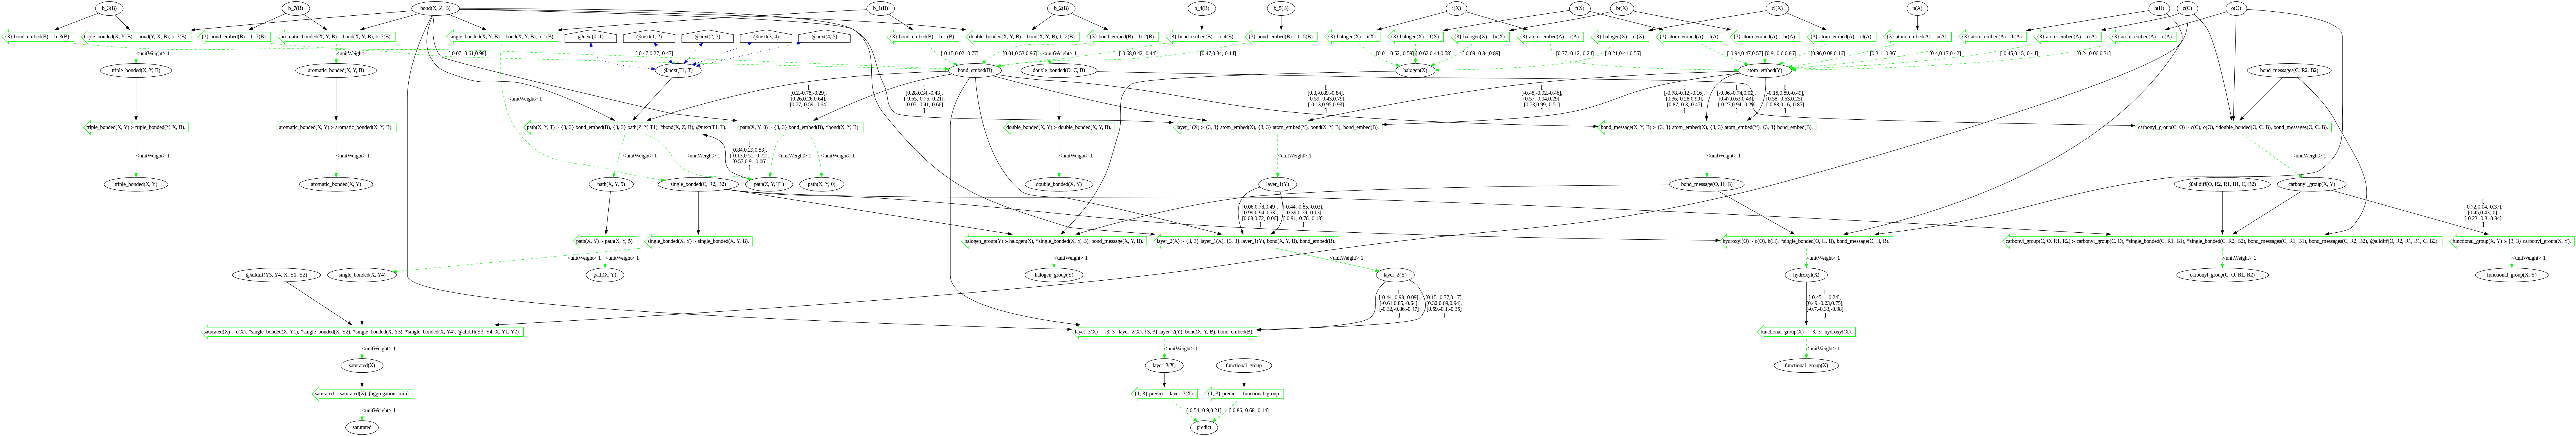

In [ ]:
print(template)
template.draw()

## Training

In [ ]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_test_cycle(template, dataset, lr=0.001, epochs=100, split=0.75):
  settings = Settings(optimizer=Adam(lr=lr), epochs=epochs, error_function=MSE())
  evaluator = get_evaluator(template, settings)

  built_dataset = evaluator.build_dataset(dataset)
  dataset_len = len(built_dataset.samples)

  train_size = int(dataset_len*split)

  idx = random.sample(list(range(dataset_len)), train_size)
  rest = list(set(range(dataset_len)) - set(idx))
  train_dataset = np.array(built_dataset.samples)[idx]
  test_dataset = np.array(built_dataset.samples)[rest]
  average_losses = []

  for current_total_loss, number_of_samples in evaluator.train(train_dataset):
      clear_output(wait=True)
      plt.ylabel("Loss")
      plt.xlabel("Epoch")

      plt.xlim(0, settings.epochs)
      
      train_loss = current_total_loss/number_of_samples
      print(train_loss)

      average_losses.append(train_loss)
      
      plt.plot(average_losses, label="Average loss")

      plt.legend()
      plt.pause(0.001)
      plt.show()

  loss = []
  for sample, y_hat in zip(test_dataset, evaluator.test(test_dataset, generator=False)):
      loss.append(round(y_hat) != sample.java_sample.target.value)

  test_loss = sum(loss) / len(test_dataset)

  return train_loss, test_loss, evaluator


0.09143505299055527


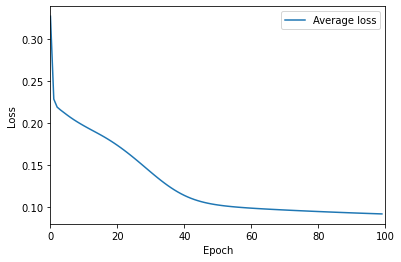

0.23404255319148937

In [ ]:
test_losses = []
for i in range(1):
  print("Training and testing model #{}".format(i))
  train_loss, test_loss, eval = train_test_cycle(template, dataset)
  test_losses.append(test_loss)

np.average(test_losses)